## FDW Crop Production Data Analysis - Burkina Faso

## Validation with FAO's National Production and CHIRPS Precipitation

Main-Maize Correlation:
           FAO        HS      PRCP
FAO   1.000000  0.998860  0.504242
HS    0.998860  1.000000  0.495302
PRCP  0.504242  0.495302  1.000000


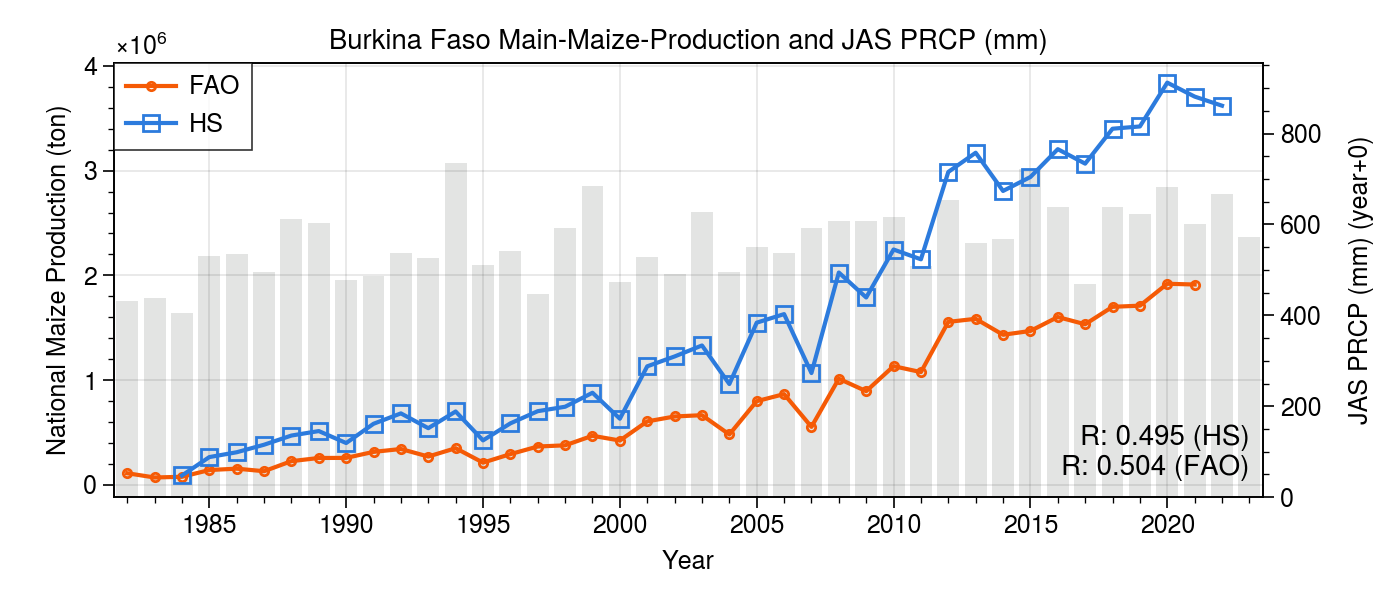

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import proplot as pplot
# Load Crop Data ------------------------------------- #
country_name, season_name, product_name_fdw, product_name_fao,  = 'Burkina Faso', 'Main', 'Maize', 'Maize (corn)'
shape_code, prcp_start_month, prcp_season_name, prcp_year_offset = 'BF2001A0', 7, 'JAS PRCP (mm)', +0
# HarvestStat
df = pd.read_csv('../public/hvstat_data.csv', index_col=0)
df = df[
    (df['country'] == country_name) &
    (df['season_name'] == season_name) &
    (df['product'].isin([product_name_fdw])) &
    (df['indicator'] == 'production')
].copy()
df['year'] = df['harvest_year']
data_hs = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').squeeze()
# FOA-STAT
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == country_name) &
    (df['cpc2_name'] == product_name_fao) &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# Merge
data = pd.concat([data_fao,data_hs], axis=1, keys=['FAO','HS']).sort_index()
data = data.reindex(np.array(range(1982,2024)))
# ---------------------------------------------------- #
# Load precipitation --------------------------------- #
fn = '../data/prcp_chirps-v2.hdf'
prcp_nat = pd.read_hdf(fn)[shape_code].resample('1M').agg('sum')
prcp_nat.index = prcp_nat.index.map(lambda x: x.replace(day=1))
prcp_nat.name = 'PRCP'
prcp_nat.index = prcp_nat.index + pd.DateOffset(years=prcp_year_offset)
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == prcp_start_month]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = prcp_season_name
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'{season_name}-{product_name_fdw} Correlation:\n{corr_value}')
# ---------------------------------------------------- #
# Comparison with Precipitation ---------------------- #
fig, ax1 = plt.subplots(figsize=(7,3))
fig.set_facecolor('white')
data.plot(ax=ax1, grid=True, markerfacecolor='None',color=['#F55A05','#2C7BDD'])
marker = ['.','s']
for i, line in enumerate(ax1.get_lines()):
    line.set_marker(marker[i])
# years = data.index
# ax1.set_xticks(years)
# ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.set_xlim([data.index[0]-0.5, data.index[-1]+0.5])
ax1.set_xlabel('Year')
ax1.set_ylabel('National Maize Production (ton)')
ax1.patch.set_facecolor('white')
# Precipitation
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label + ' (year+%d)'%prcp_year_offset, labelpad=10)
ax2.grid(False)
ax1.set_zorder(1)  
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(loc='upper left')
ax1.annotate(
    'R: %.3f (HS)\nR: %.3f (FAO)' % (corr_value.loc['HS','PRCP'], corr_value.loc['FAO','PRCP']), 
    xy=(1, 0.2), xycoords='axes fraction', fontsize=10,
    xytext=(-5, -5), textcoords='offset points',
    ha='right', va='top'
)
title = f'{country_name} {season_name}-{product_name_fdw}-Production and {prcp_label}'
ax1.set_title(title)
fig.tight_layout()
plt.show()
# ---------------------------------------------------- #

In [5]:
data['FAO']*2 - data['HS']

year
1982              NaN
1983              NaN
1984     65140.000000
1985     18116.000000
1986     -1638.000000
1987   -122374.000000
1988    -17693.800000
1989        -6.000000
1990    116230.000000
1991     46800.000000
1992      2800.000000
1993         0.000000
1994         2.000000
1995         0.000000
1996         0.000000
1997     29231.250000
1998      9470.056000
1999     58216.390000
2000    215442.000000
2001     80592.910000
2002     80168.096000
2003        -2.000000
2004        -2.000000
2005     49340.734000
2006    103060.000000
2007     40000.000000
2008        -4.000000
2009         2.000000
2010     19936.000000
2011        -2.000000
2012    124924.000000
2013        -4.000000
2014     59998.000000
2015         0.500212
2016         0.804132
2017         8.000000
2018        -0.602752
2019        -0.001576
2020         0.000000
2021    118976.000000
2022              NaN
2023              NaN
dtype: float64

Correlation:
           FDW      PRCP
FDW   1.000000  0.493589
PRCP  0.493589  1.000000


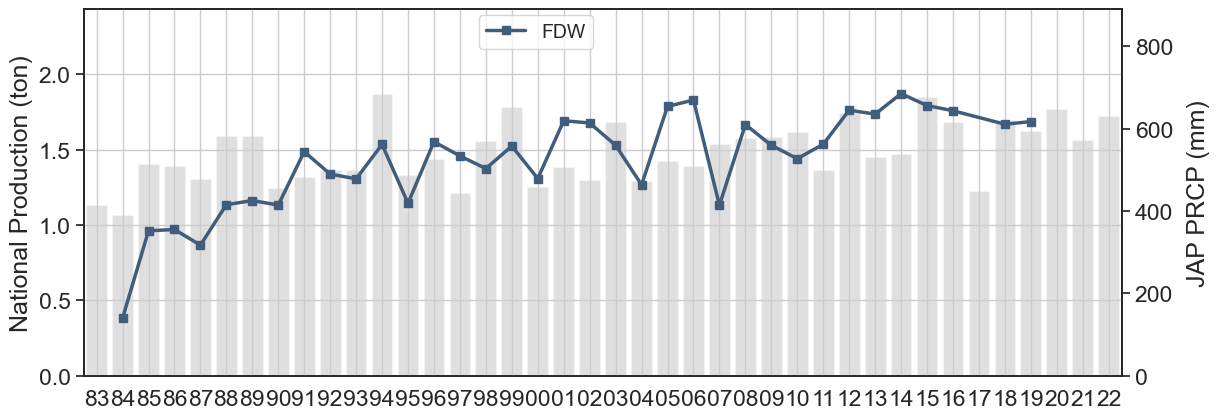

In [3]:
# Load precipitation --------------------------------- #
prcp = pd.read_hdf('../data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == 7]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = 'JAP PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1983,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'])
marker = ['s','*']
for i, line in enumerate(ax1.get_lines()): line.set_marker(marker[i])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_ylim([0, data.max().max()*1.3])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #

### Annual (Main-season) Production - Maize

Correlation:
           FDW       FAO      PRCP
FDW   1.000000  0.998577  0.516686
FAO   0.998577  1.000000  0.524706
PRCP  0.516686  0.524706  1.000000


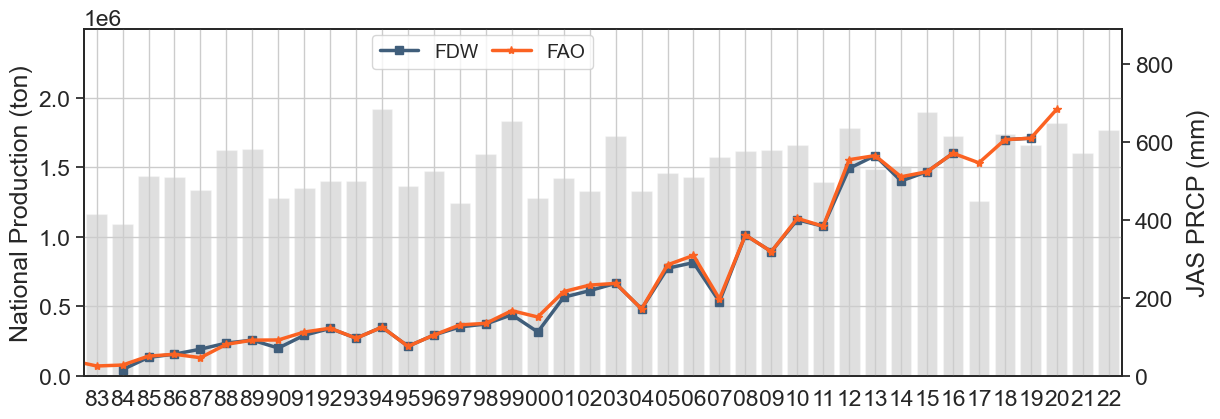

In [4]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
# Deyr-season
df = df[
    (df['season_name'] == 'Main') &
    (df['product'].isin(['Maize'])) &
    (df['indicator'] == 'production')
]
df['year'] = df['planting_year']
data_fdw = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load FAO-STAT National Production Data ------------- #
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == 'Burkina Faso') &
    (df['cpc2_name'] == 'Maize (corn)') &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# ---------------------------------------------------- #
data = pd.concat([data_fdw, data_fao], axis=1, keys=['FDW','FAO']).sort_index()

# Load precipitation --------------------------------- #
prcp = pd.read_hdf('../data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == 7]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = 'JAS PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1983,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'])
marker = ['s','*']
for i, line in enumerate(ax1.get_lines()): line.set_marker(marker[i])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_ylim([0, data.max().max()*1.3])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #

### Annual (Main-season) Production - Sorghum

Correlation:
           FDW       FAO      PRCP
FDW   1.000000  0.918511  0.544052
FAO   0.918511  1.000000  0.494460
PRCP  0.544052  0.494460  1.000000


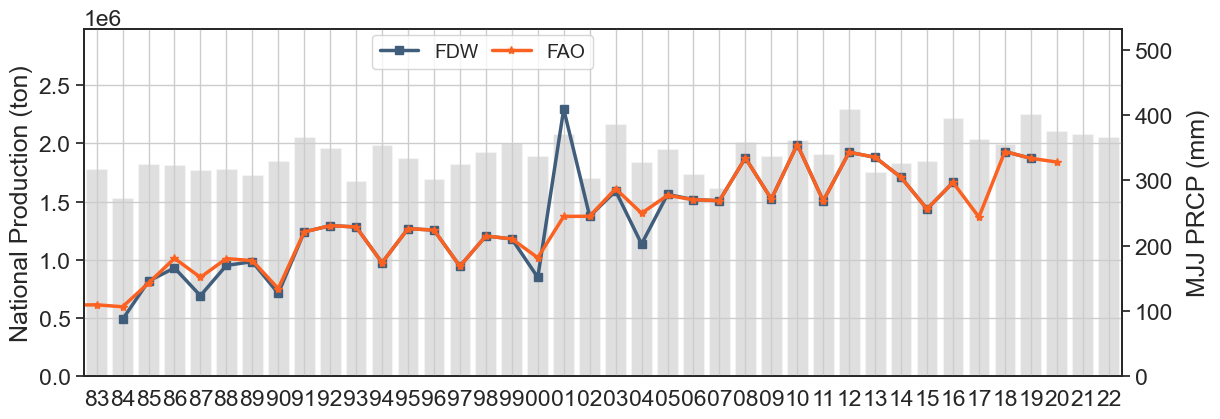

In [5]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
# Deyr-season
df = df[
    (df['season_name'] == 'Main') &
    (df['product'].isin(['Sorghum'])) &
    (df['indicator'] == 'production')
]
df['year'] = df['planting_year']
data_fdw = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load FAO-STAT National Production Data ------------- #
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == 'Burkina Faso') &
    (df['cpc2_name'] == 'Sorghum') &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# ---------------------------------------------------- #
data = pd.concat([data_fdw, data_fao], axis=1, keys=['FDW','FAO']).sort_index()

# Load precipitation --------------------------------- #
prcp = pd.read_hdf('../data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == 5]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = 'MJJ PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1983,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'], alpha=1)
marker = ['s','*']
for i, line in enumerate(ax1.get_lines()): line.set_marker(marker[i])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_ylim([0, data.max().max()*1.3])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #